# Training a GPT-2 Language Model

In this notebook we train a GPT-2 language model on the IMSLP and/or target data.  This code can be used to train two different language models: (a) one that is trained on target data, and (b) one that is trained on IMSLP data and finetuned on target data.  For (a), you can stop at the end of the section entitled "Train Language Model".

In [2]:
%matplotlib inline

In [1]:
from pathlib import Path
import json
from train_utils import plotLosses
from fastai.text import Config

/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kdey/ttmp/micromamba/envs/pse/lib/python3.7/site-packages/tensorflow/python/framework/dt

In [2]:
bpe_path = Config.data_path()/'bscore_lm/bpe_data'
bpe_path.mkdir(exist_ok=True, parents=True)

### Train Language Model

In [3]:
data_type = 'target' # 'target' or 'imslp'

In [4]:
lm_train_file = bpe_path/f'bpe_lm_{data_type}_train.txt'
lm_valid_file = bpe_path/f'bpe_lm_{data_type}_valid.txt'
tok_path = bpe_path/f'tokenizer_{data_type}'
output_model_path = bpe_path/f'models/gpt2_train-{data_type}_lm'

In [5]:
# changes from defaults:
# vocab_size: 50257 -> 30000
# n_positions: 1024 -> 514
# n_ctx: 1024 -> 514
# n_layer: 12 -> 6
config = {
    "architectures": [
        "GPT2LMHeadModel"
    ],
    "vocab_size": 30000,
    "n_positions": 514,
    "n_ctx": 514,
    "n_embd": 768,
    "n_layer": 6,
    "n_head": 12,
    "resid_pdrop": 0.1,
    "embd_pdrop": 0.1,
    "attn_pdrop": 0.1,
    "layer_norm_epsilon": 1e-5,
    "initializer_range": 0.02,
    "summary_type": "cls_index",
    "summary_use_proj": True,
    "summary_activation": None,
    "summary_proj_to_labels": True,
    "summary_first_dropout": 0.1
    }

In [6]:
with open(f"{tok_path}/config.json", 'w') as fp:
    json.dump(config, fp)

In [7]:
cmd = f"""
python ./run_language_modeling.py
--train_data_file {lm_train_file}
--output_dir {output_model_path}
--model_type gpt2
--eval_data_file {lm_valid_file}
--line_by_line
--config_name {tok_path}
--tokenizer_name {tok_path}
--do_train
--do_eval
--evaluate_during_training
--per_gpu_train_batch_size 16
--per_gpu_eval_batch_size 16
--learning_rate 1e-4
--num_train_epochs 60
--logging_steps 2000
--save_steps 2000
--seed 42
--overwrite_output_dir
""".replace("\n", " ")
#--save_total_limit 2
#--should_continue
# target data: batch size 16, 204 steps per epoch, 12 epochs
# imslp data: batch size 16, 7180 steps per epoch, ? epochs
print(lm_train_file, lm_valid_file)

/home/kdey/.fastai/data/bscore_lm/bpe_data/bpe_lm_target_train.txt /home/kdey/.fastai/data/bscore_lm/bpe_data/bpe_lm_target_valid.txt


In [10]:
!echo {cmd} > train_gpt.sh

In [11]:
# you may need to run this in a bash shell with correct virtual environment
# you might also need to run `chmod +x train_gpt.sh` to make the script executable
#!./train_gpt.sh

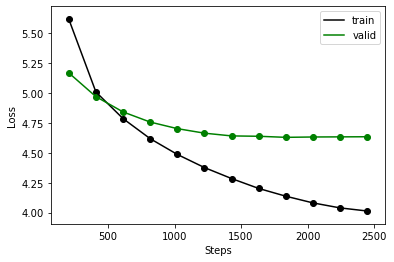

In [10]:
plotLosses(output_model_path/'eval_results.txt')

### Finetune Language Model

This section only applies for the LM trained on IMSLP data.

In [11]:
finetuned_models_path = bpe_path/'models/gpt2_train-imslp_finetune-target_lm'
lm_train_file = bpe_path/'bpe_lm_target_train.txt'
lm_valid_file = bpe_path/'bpe_lm_target_valid.txt'

In [12]:
cmd = f"""
python ./run_language_modeling.py
--train_data_file {lm_train_file}
--output_dir {finetuned_models_path}
--model_type gpt2
--eval_data_file {lm_valid_file}
--line_by_line
--model_name_or_path {output_model_path}
--tokenizer_name {output_model_path}
--do_train
--do_eval
--evaluate_during_training
--per_gpu_train_batch_size 16
--per_gpu_eval_batch_size 16
--learning_rate 5e-5
--num_train_epochs 12
--logging_steps 204
--save_steps 204
--seed 42
--overwrite_output_dir
""".replace("\n", " ")
#--save_total_limit 2
#--should_continue

In [13]:
!echo {cmd} > train_lm.sh

In [ ]:
# you may need to run this in a bash shell with correct virtual environment
# you might also need to run `chmod +x train_gpt.sh` to make the script executable
#!./train_gpt.sh

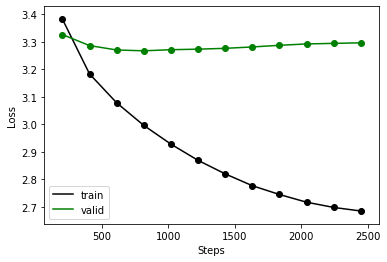

In [14]:
plotLosses(finetuned_models_path/'eval_results.txt')